In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

import keras
import tensorflow
from keras.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from model_persistence import get_persistence_dataset, train_test_split, calculate_errors, plot_error
from features_preprocessing import make_shifted_features, transform_to_windows


Using TensorFlow backend.
/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ns/anaconda3/envs/bk_p

### Multiple Parallel output LSTM Model

Define a two stage lstm architecture with default 50 neurons and 25 neurons


In [2]:
###define an LSTM model
#takes in parallel inputs and outputs an equal number of parallel outputs
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

###### Setup and run crossvalidation of the model

- number of crossvalidations set to 10 over 1 year period.
- each sample is shaped (lags, hour_slices).
- number of lags is 7 day look back. i.e. using last 7 days to predict next 24 hours.

In [20]:
def run_lstm_pipe(n_lags=7, n_crossvals=5, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31'):

    n_hours = 24

    verbose = 0
    
    if show_verbose:
        verbose = 1

    print('Crossvalidation run congifuration:')
    print('Number of lag features: {}' .format(n_lags))
    print('Number of crossvalidations: {}' .format(n_crossvals))
    print('Date range from {} to {}'.format(period_start, period_end))

    #load the inital data
    working = get_persistence_dataset(start=period_start, stop=period_end)

    #transform into days and hours windows
    working_t = transform_to_windows(working)

    #normalize and return the inverse sacler
    working_norm, scaler = normalize_df(working_t)

    #split the sequences into X with lags, and Y the predicted value
    X, y = split_sequences(working_norm.values, n_lags)
    
    print('X shape: {}'.format(X.shape))
    print('y shape: {}'.format(y.shape))
    
    #creates set sequences of the time series to cross validate on. 
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X, y):

        lstm_base = lstm_parallel_out(n_lags, n_hours, learning_rate=1e-2)

        lstm_base.fit(X[train], y[train], epochs=20, verbose=0, shuffle=False)

        predict = lstm_base.predict(X[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler.inverse_transform(predict)
        actual = scaler.inverse_transform(y[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)

    #convert results to numpy array for easy manipulation
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    #calculate and display the crossvalidated mean average errors 
    mae = get_sample_total_mae(actuals, predictions)

    #print a selection of the cross validated predictions. See how the sample predictions evolved.
    inspect_cv_predictions(actuals, predictions)

Crossvalidation run congifuration:
Number of lag features: 3
Number of crossvalidations: 9
Date range from 2017-01-01 to 2017-12-31
Sample 0 total MAE 1827.07, MAPE 6.51%
Sample 1 total MAE 2533.99, MAPE 9.77%
Sample 2 total MAE 1977.46, MAPE 7.24%
Sample 3 total MAE 2086.31, MAPE 6.87%
Sample 4 total MAE 2307.15, MAPE 7.90%
Sample 5 total MAE 1961.66, MAPE 7.14%
Sample 6 total MAE 1872.23, MAPE 6.79%
Sample 7 total MAE 1877.41, MAPE 6.71%
Sample 8 total MAE 2396.09, MAPE 8.56%
Mean crossvalidation MAE 2093.26 MAPE 7.50%


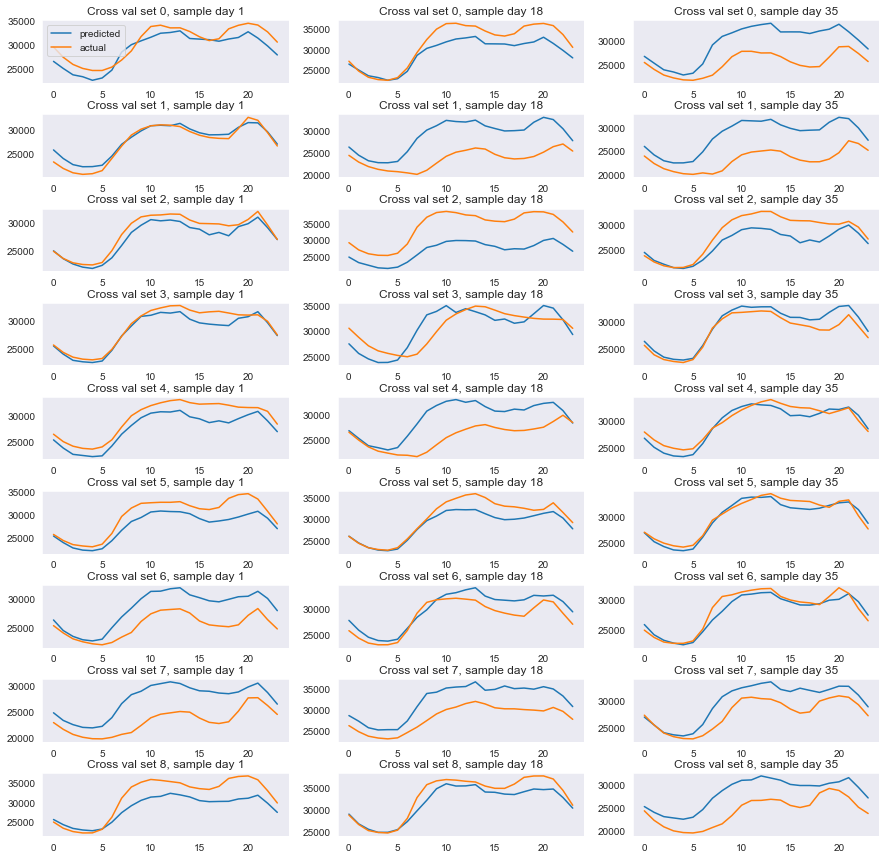

In [238]:
run_lstm_pipe(n_lags=3, n_crossvals=9, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 7
Number of crossvalidations: 9
Date range from 2017-01-01 to 2017-12-31
Sample 0 total MAE 1910.45, MAPE 7.07%
Sample 1 total MAE 2517.35, MAPE 9.88%
Sample 2 total MAE 2051.06, MAPE 7.45%
Sample 3 total MAE 2042.19, MAPE 7.00%
Sample 4 total MAE 2301.29, MAPE 8.09%
Sample 5 total MAE 1902.60, MAPE 6.84%
Sample 6 total MAE 1830.16, MAPE 6.81%
Sample 7 total MAE 1762.34, MAPE 6.29%
Sample 8 total MAE 2816.51, MAPE 9.68%
Mean crossvalidation MAE 2125.99 MAPE 7.68%


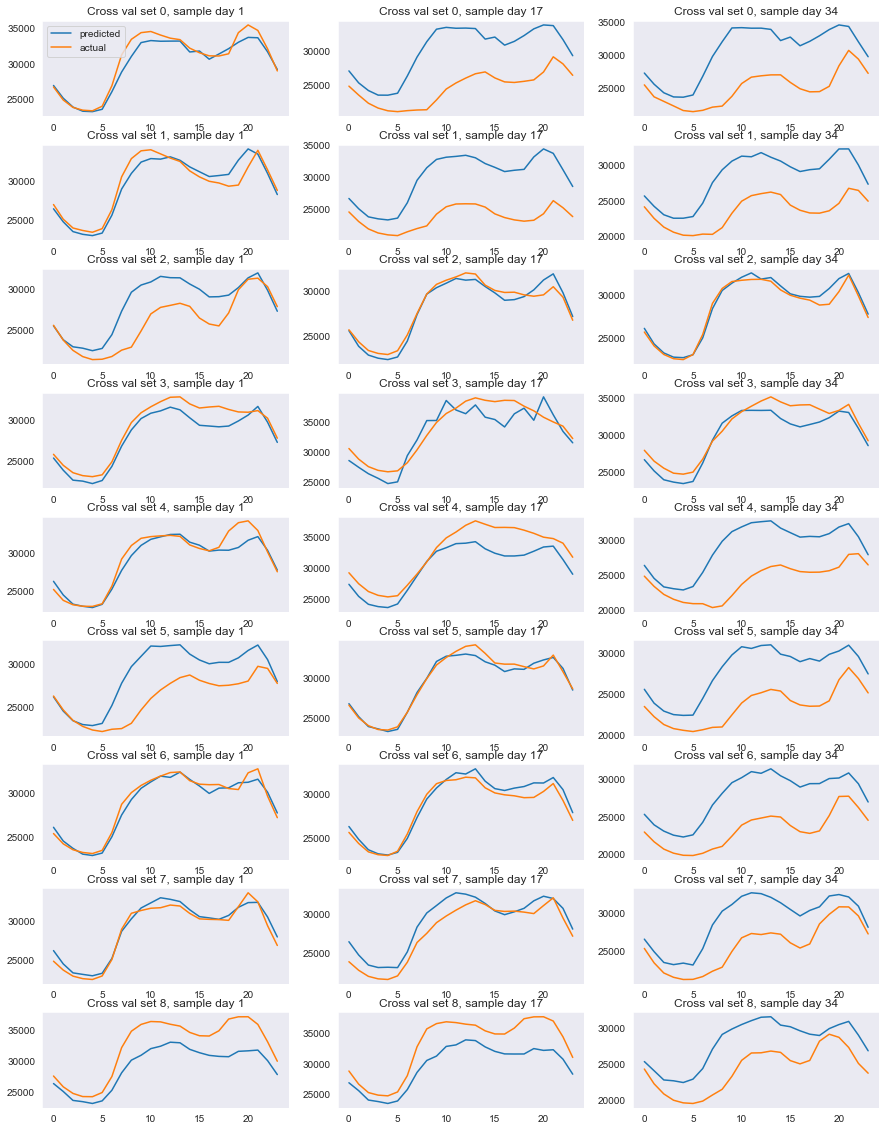

In [10]:
run_lstm_pipe(n_lags=7, n_crossvals=9, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 14
Number of crossvalidations: 9
Date range from 2017-01-01 to 2017-12-31
Sample 0 total MAE 1965.75, MAPE 7.32%
Sample 1 total MAE 2852.69, MAPE 11.27%
Sample 2 total MAE 2100.18, MAPE 7.78%
Sample 3 total MAE 2331.10, MAPE 7.92%
Sample 4 total MAE 2377.63, MAPE 8.35%
Sample 5 total MAE 1925.95, MAPE 7.07%
Sample 6 total MAE 1923.87, MAPE 7.18%
Sample 7 total MAE 1965.30, MAPE 6.98%
Sample 8 total MAE 2585.82, MAPE 8.98%
Mean crossvalidation MAE 2225.36 MAPE 8.09%


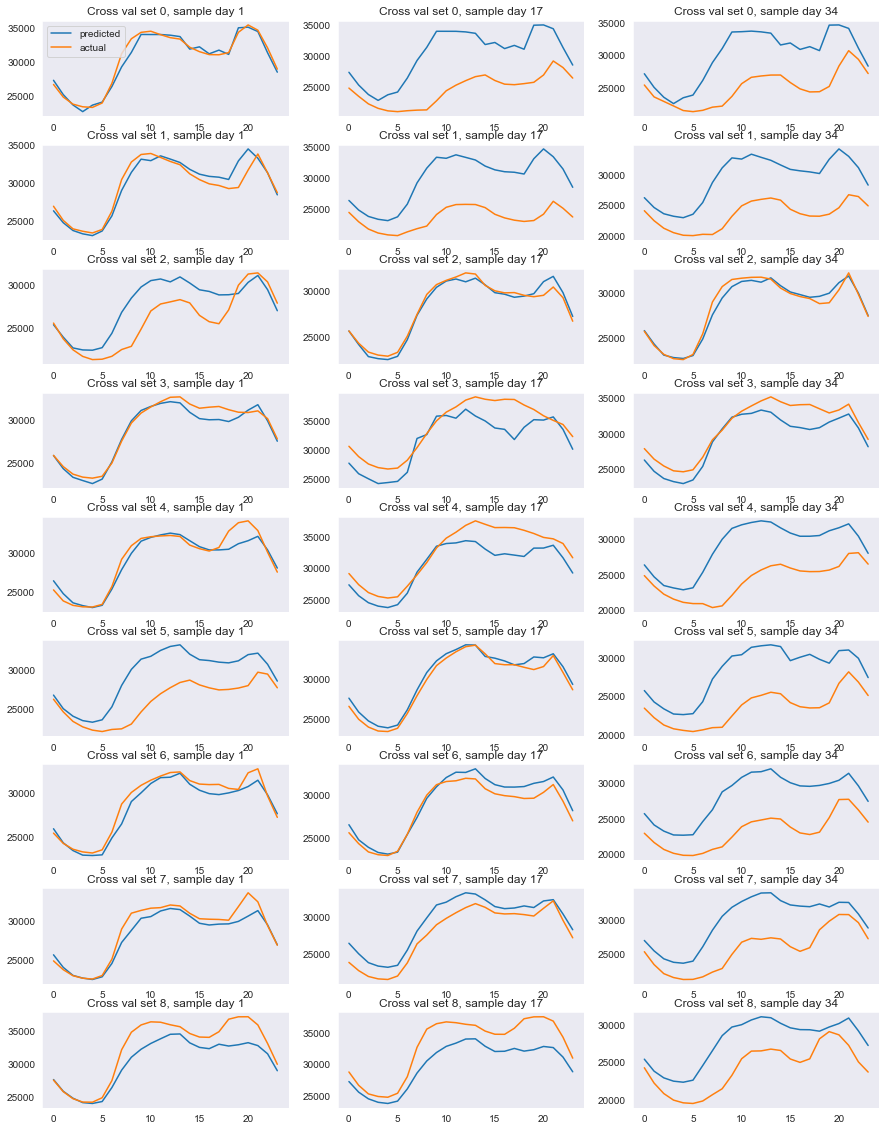

In [11]:
run_lstm_pipe(n_lags=14, n_crossvals=9, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 180
Number of crossvalidations: 2
Date range from 2015-01-01 to 2017-12-31
305/305 [==============================] - 5s 15ms/step
Sample 0 total MAE 17034.15, MAPE 58.69%
Sample 1 total MAE 2195.15, MAPE 8.02%
Mean crossvalidation MAE 9614.65 MAPE 33.36%


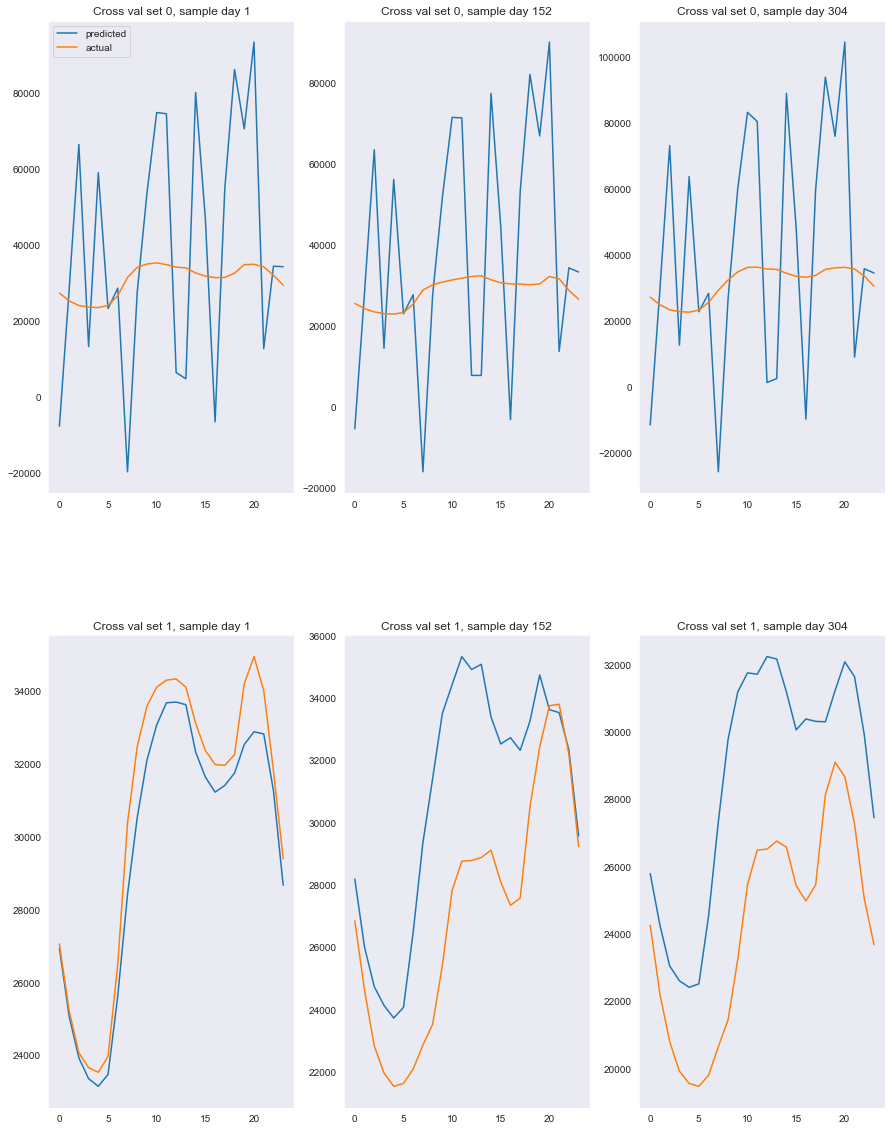

In [12]:
run_lstm_pipe(n_lags=180, n_crossvals=2, show_verbose=True, period_start = '2015-01-01', period_end = '2017-12-31')

In [21]:
run_lstm_pipe(n_lags=2, n_crossvals=2, show_verbose=True, period_start = '2015-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 2
Number of crossvalidations: 2
Date range from 2015-01-01 to 2017-12-31
X shape: (1094, 2, 24)
y shape: (1094, 24)


KeyboardInterrupt: 

### HELPER FUNCTIONS
###### Define a function to calculate and capture the mae

This could be done in keras directly with the model.evaluate feature. However that will return the scaled values. We are interested in comparing our results with other models and therefore choose to use the model.predict.

In [4]:
def normalize_df(data):
    
    #normalize the dataset for working with the lstm nn
    scaler = MinMaxScaler().fit(data.values)
    data_normd = scaler.transform(data.values)

    data = pd.DataFrame(data_normd, index=data.index, columns=data.columns)
    
    return data, scaler

In [5]:
def sample_mape(actual, predicted):
    
    #calcualtes the mean absolute percent error per cross validated sample
    #returns as a percentage
    
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [6]:
#define a function to calcualte and capture the mae

def get_sample_total_mae(actual, predicted):
    #list to save scores
    maes = []
    mapes = []

    #loop through each crossvalidation sample
    for i in range(actual.shape[0]):
        
        #calcualte the mae and save to list
        mae = mean_absolute_error(actual[i], predicted[i])
        mape = sample_mape(actual[i], predicted[i])
        
        maes.append(mae)
        mapes.append(mape)
        print('Sample {} total MAE {:.2f}, MAPE {:.2f}%'.format(i,mae, mape))
        
    maes_total = np.mean(maes)
    mape_total = np.mean(mapes)
    
    print('Mean crossvalidation MAE {:.2f} MAPE {:.2f}%'. format(maes_total, mape_total))
        
    return maes, mapes

In [7]:
def inspect_cv_predictions(actuals, predictions):

    #the number of cross validation sets
    plots = predictions.shape[0]
    
    #the first day, middle day, and last days of the validation set
    days = [1, int(predictions.shape[1]/2), predictions.shape[1]-1]
    
    #set figure
    fig, axs = plt.subplots(plots,3, figsize=(15,20))

    #loop through the samples then loop through the days
    for i, axe in zip(range(plots), axs):
        for day, ax in zip(days, axe):
            
            #plot the predictions
            ax.plot(predictions[i][day], label='predicted')
            #plot actual values
            ax.plot(actuals[i][day], label='actual')
            ax.set_title('Cross val set {}, sample day {}'.format(i,day))

    #position the legend in the top left position of the top left chart.
    axs[0][0].legend(loc=2)
    plt.subplots_adjust(hspace=0.3)

In [22]:
def split_sequences(sequences, n_steps, idx=0, multivar=False):
    """
    Function modified for use from Deep learning time series forecasting by Jason Brownlee
    """
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #retun only the feature target in the indx column 
        y = y[:,idx]
    
    return X, y

# Multivariable - Multiple Parallel Output LSTM

In [26]:
###define an LSTM model
#takes in parallel inputs and outputs an equal number of parallel outputs
def lstm_multi_in_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [50]:
def run_multi_var_lstm_pipe(n_lags=2, n_crossvals=2, epochs=5, lr = 1e-3, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31'):

    
    n_hours = 24


    #load the inital data
    X_multi, y_multi, scaler_multi = get_lstm_multivariable_data_3d(start=period_start, stop=period_end, n_lags=n_lags)


    n_features = X_multi.shape[1]


    if show_verbose:
        verbose = 1
    else:
        verbose = 0


    print('Crossvalidation run congifuration:')
    print('Number of lag features: {}' .format(n_lags))
    print('Number of crossvalidations: {}' .format(n_crossvals))
    print('Number of total feature vectors: {}' .format(n_features))
    #print('Date range from {} to {}'.format(period_start, period_end))


    print(X_multi.shape)
    print(y_multi.shape)


    #creates set sequences of the time series to cross validate on. 
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    # #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X_multi, y_multi):

        lstm_multi = lstm_multi_in_parallel_out(n_features, n_hours, learning_rate=lr)


        lstm_multi.fit(X_multi[train], y_multi[train], epochs=epochs, verbose=verbose, shuffle=False)

        predict = lstm_multi.predict(X_multi[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler_multi.inverse_transform(predict)
        actual = scaler_multi.inverse_transform(y_multi[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)


    #convert results to numpy array for easy manipulation
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    print(predictions.shape)
    print(actuals.shape)
    #calculate and display the crossvalidated mean average errors 
    mae = get_sample_total_mae(actuals, predictions)

    #print a selection of the cross validated predictions. See how the sample predictions evolved.
    inspect_cv_predictions(actuals, predictions)

Crossvalidation run congifuration:
Number of lag features: 2
Number of crossvalidations: 2
Number of total feature vectors: 20
(28, 20, 24)
(28, 24)
Epoch 1/500
10/10 [==============================] - 16s 2s/step - loss: 0.3952
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3702
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3450
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3265
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 0.2823
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 0.2530
Epoch 7/500
10/10 [==============================] - 0s 8ms/step - loss: 0.2584
Epoch 8/500
10/10 [==============================] - 0s 8ms/step - loss: 0.2147
Epoch 9/500
10/10 [==============================] - 0s 7ms/step - loss: 0.2035
Epoch 10/500
10/10 [==============================] - 0s 7ms/step - loss: 0.1859
Epoch 11/500
10/10 [==============================

Epoch 101/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 102/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0864
Epoch 103/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0903
Epoch 104/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0810
Epoch 105/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0818
Epoch 106/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0790
Epoch 107/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0777
Epoch 108/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0795
Epoch 109/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0730
Epoch 110/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0767
Epoch 111/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0714
Epoch 112/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0737
Epoch 113/500
10

Epoch 201/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0553
Epoch 202/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0517
Epoch 203/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0527
Epoch 204/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0538
Epoch 205/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0509
Epoch 206/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0507
Epoch 207/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0512
Epoch 208/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0522
Epoch 209/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0517
Epoch 210/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0508
Epoch 211/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0496
Epoch 212/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0499
Epoch 213/500
10

Epoch 301/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0473
Epoch 302/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0408
Epoch 303/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0475
Epoch 304/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0405
Epoch 305/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0453
Epoch 306/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0402
Epoch 307/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0422
Epoch 308/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0407
Epoch 309/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0388
Epoch 310/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0403
Epoch 311/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0377
Epoch 312/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0380
Epoch 313/500
10

Epoch 401/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0222
Epoch 402/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0203
Epoch 403/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0197
Epoch 404/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0217
Epoch 405/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0200
Epoch 406/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 407/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0240
Epoch 408/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0257
Epoch 409/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 410/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0244
Epoch 411/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 412/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 413/500
10

9/9 [==============================] - 6s 715ms/step
Epoch 1/500
19/19 [==============================] - 16s 868ms/step - loss: 0.4981
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 0.4522
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3937
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 0.5942
Epoch 6/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3223
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3552
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3625
Epoch 9/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3595
Epoch 10/500
19/19 [==============================] - 0s 5ms/step - loss: 0.3504
Epoch 11/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3369
Epoch 12/500
19/19 [==============================] - 0s 4ms/s

Epoch 102/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1088
Epoch 103/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1735
Epoch 104/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1322
Epoch 105/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1606
Epoch 106/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1562
Epoch 107/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1245
Epoch 108/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1492
Epoch 109/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1132
Epoch 110/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1262
Epoch 111/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1379
Epoch 112/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1300
Epoch 113/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1136
Epoch 114/500
19

Epoch 202/500
19/19 [==============================] - 0s 5ms/step - loss: 0.0931
Epoch 203/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0935
Epoch 204/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0955
Epoch 205/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0932
Epoch 206/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0929
Epoch 207/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0936
Epoch 208/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0934
Epoch 209/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0927
Epoch 210/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0925
Epoch 211/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0929
Epoch 212/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0944
Epoch 213/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0962
Epoch 214/500
19

Epoch 302/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0893
Epoch 303/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0964
Epoch 304/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0891
Epoch 305/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0907
Epoch 306/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0923
Epoch 307/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0886
Epoch 308/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0900
Epoch 309/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0913
Epoch 310/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0886
Epoch 311/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0891
Epoch 312/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0909
Epoch 313/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0889
Epoch 314/500
19

Epoch 402/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0833
Epoch 403/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0839
Epoch 404/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0826
Epoch 405/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0814
Epoch 406/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0810
Epoch 407/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 408/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 409/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0808
Epoch 410/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0803
Epoch 411/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0802
Epoch 412/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0811
Epoch 413/500
19/19 [==============================] - 0s 4ms/step - loss: 0.0833
Epoch 414/500
19

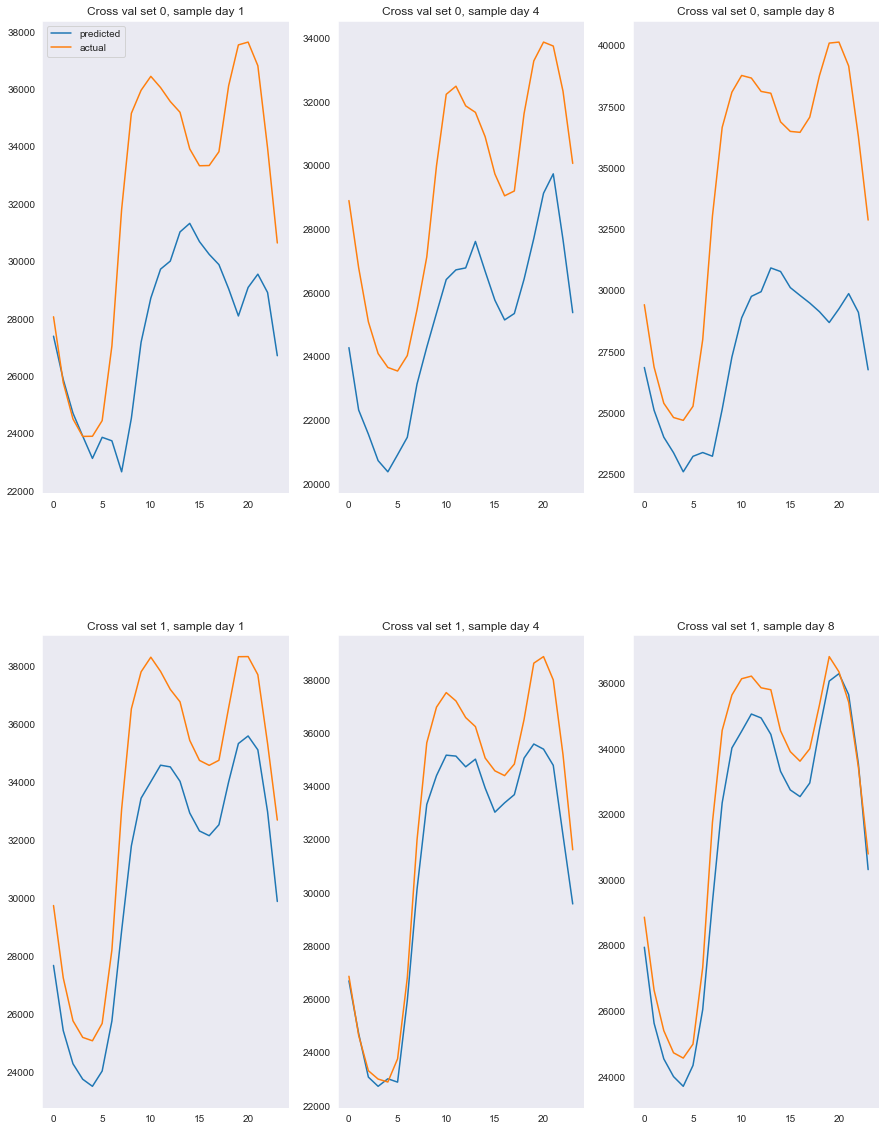

In [47]:
run_multi_var_lstm_pipe(n_lags=2, n_crossvals=2, epochs=100, lr = 1e-2, show_verbose=True, period_start = '2017-01-01', period_end = '2017-12-31')

In [49]:
run_multi_var_lstm_pipe(n_lags=7, n_crossvals=2, epochs=500, lr = 1e-2, show_verbose=True, period_start = '2017-01-01', period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of lag features: 7
Number of crossvalidations: 2
Number of total feature vectors: 70
(23, 70, 24)
(23, 24)


ValueError: Initializer for variable lstm_105/kernel/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.

# Mulitvariate Preprocessing helper functions

In [28]:
def get_lstm_multivariable_data_3d(start='2015-01-01', stop='2015-01-05', n_lags=2):

    #load in the prepared dataset
    all_data = pd.read_csv('./data/lstm/nn_dataset_2015_2018.csv', parse_dates=True, index_col=0)

    #select data time slice
    data = all_data[start: stop].copy()
    
    #reshape the energy load columns to prepare for minmax scaling
    energy = data['actual_load'].values.reshape(-1,1)
    
    #minmax scale the energy column
    scaler = MinMaxScaler().fit(energy)
    data_normd = scaler.transform(energy)
    
    #reset the energy column to the actual loads
    data['actual_load'] = data_normd.copy()
    
    #create single columns with time features
    data.loc[:,'year'] = data.index.year
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hours'] = data.index.hour
    
    hours_tup = [] 

    #for each unique hour isolate the features and dates
    for h in data.hours.unique():
        
        #boolean mask for each hour of the day
        hour = data[data.hours==h].copy()
        #drop the unneeded columns
        hour.drop(['year', 'month', 'day', 'hours'], axis=1, inplace=True)
        #reshape 2D into a 3D matrix for stacking
        hour = np.reshape(hour.values, (hour.shape[0], hour.shape[1], 1))
        #append each 3d slice into list
        hours_tup.append(hour)
    
    
    tup = tuple(hours_tup)
    
    #stack all the 3D arraysinto 1 single 3D array
    hours_stacked = np.dstack(tup)
    
    #make samples from hours stacked. result is 4D and 2D
    X_4d, y = split_sequences(hours_stacked, n_lags, idx=0, multivar=True)
    
    
    X = []

    #flatten the 2nd and 3rd dimensions together to have a final array of samples, lags & features, hours
    for j in range(len(X_4d)):
        #reshape the inner dimensions
        n = X_4d[j].reshape(-1, hours_stacked.shape[-1])
        X.append(n)
    
    X = np.array(X)
    
    
    return X, y, scaler

In [25]:
X_, y_, scaler_energy = get_lstm_multivariable_data_3d(start='2015-01-01', stop='2015-01-05', n_lags=2)
X_.shape, y_.shape

((3, 20, 24), (3, 24))

In [14]:
def get_lstm_multivariable_data_4d(start='2015-01-01', stop='2015-01-05', n_lags=2):

    #load in the prepared dataset
    all_data = pd.read_csv('./data/lstm/nn_dataset_2015_2018.csv', parse_dates=True, index_col=0)

    #select data time slice
    data = all_data[start: stop].copy()
    
    #list to store the windows of 2D feature data
    windowed_data = []

    #for each 2d feautre window 
    for col in data.columns:
        #transform each column to row of dates, with columns as the hourly slices
        window = transform_to_windows(data, load_type=col)

        #if the column is actual load, we need to scale it, otherwise all columns are already scaled
        if col == 'actual_load':
            window, scaler = normalize_df(window)

        #reshape each 2D feature window into 3D so it can be stacked
        window = np.reshape(window.values, (window.shape[0], window.shape[1], 1))
        
        #append to list
        windowed_data.append(window)
        
    #convert list of 2D feature windows to a numpy array
    windowed_data = np.array(windowed_data)

    tup = []

    #make a list of each 2D dataslice to stack
    for i in range(len(windowed_data)):
        tup.append(windowed_data[i])

    #tun into a tuple
    tup = tuple(tup)

    #stack up the 2d feature windows to a 3D array
    windows_stacked = np.dstack(tup)

    #split the 3D data into 4D slices of X and y. multivar True to select only the index value of the y array.
    #indx is the location of the y target values.
    X, y = split_sequences(windows_stacked, n_lags, idx=0, multivar=True)
    
    return X, y, scaler

In [243]:
X, y, scaler_y = get_lstm_multivariable_data(start='2015-01-01', stop='2015-01-05')
X.shape, y.shape

((3, 2, 24, 10), (3, 24, 1))

In [91]:
scores = np.array(scores)
actual_vals = np.array(actual_vals)

In [93]:
maes = []

for i in range(scores.shape[0]):
    
    mae = mean_absolute_error(actual_vals[i], scores[i])
    maes.append(mae)

In [94]:
maes

[0.5965328764129313, 0.25943621648619375, 0.26015487684509203]

In [80]:
print(X.shape, y.shape)
# summarize the data
for i in range(1):
    print(X[i], y[i])

(57, 2, 24) (57, 24)
[[0.2112286  0.29476425 0.23479888 0.15248602 0.04742967 0.
  0.         0.01720532 0.         0.         0.         0.
  0.         0.00400724 0.0298487  0.02164616 0.03865194 0.09105181
  0.2302613  0.27583761 0.27747832 0.1798881  0.23009815 0.22965681]
 [0.62059416 0.61368238 0.62285625 0.63079946 0.64088967 0.6913765
  0.7657269  0.83530126 0.82919134 0.80326047 0.75156901 0.71039223
  0.68958865 0.66546019 0.64962005 0.65899072 0.65879665 0.64346093
  0.65590609 0.7188148  0.72638856 0.6698858  0.61741185 0.60252536]] [0.45619335 0.47758172 0.54240723 0.60541031 0.61290323 0.65914037
 0.72750075 0.75912557 0.73720042 0.73233473 0.68614274 0.62673303
 0.59586782 0.56650724 0.54809338 0.54970722 0.54112719 0.52227992
 0.48563689 0.60433264 0.64272322 0.57407833 0.52226463 0.5211526 ]


In [136]:
bscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in bscv.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] TEST: [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] TEST: [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98 

In [72]:
X_train.shape, X_test.shape

((30, 7, 24), (17, 7, 24))

In [73]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [31]:
def split_sequences(sequences, n_steps):
    """
    Function modified for use from Deep learning time series forecasting by Jason Brownlee
    """
    
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    
        X.append(seq_x)
        y.append(seq_y)
        
        #how can i add the average of the 14th, 21st, 28th days as a single slice to the end of each sample?
    
    return np.array(X), np.array(y)

In [21]:
import numpy as np

def split_sequences(sequences, n_steps):
    """
    Function modified for use from Deep learning time series forecasting by Jason Brownlee
    """
    
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    
        X.append(seq_x)
        y.append(seq_y)
        
        #how can i add the average of the 14th, 21st, 28th days as a single slice to the end of each sample?
    
    return np.array(X), np.array(y)

in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

print(dataset)

In [24]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

print(dataset)

[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]


In [41]:
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

print(X.shape, y.shape)
# summarize the data
for i in range(2):
    print(X[i], y[i])

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]


## Shape the data for LSTM


(samples, timesteps, features)

Samples: length of train and test sets
Timesteps: 24 * number of days
- Training with 3 days autoregressive feautres 24 * 3: 72
- Target is always same as forecast horizon of 24 steps
Features: number of input series. In this case 1. I.e. adding temperature, and day type then 3

In [43]:
def prep_data(train, test, n_features=1):
    
    #split into X and Y train, test
    X_train, Y_train = make_xy_features(train)
    X_test, Y_test = make_xy_features(test)
    
    
    #get the details of the assets
    #number of autoregressive feautres * hours in day
    n_steps_in = X_train.shape[1]

    #number of steps ahead to forecast
    n_steps_out = Y_train.shape[1]

    #the number of samples in the test
    n_samples_train = X_train.shape[0] 
    n_samples_test = X_test.shape[0]    
    
    
    #reshape in preparation for the nn
    X_train = np.reshape(X_train.values, (n_samples_train, n_steps_in, n_features))
    X_test = np.reshape(X_test.values, (n_samples_test, n_steps_in, n_features))
    
    #convert to numpy arrays
    Y_train = Y_train.values
    Y_test = Y_test.values
    
    #set the input shape for the neural_network
    input_shape = (n_steps_in, n_features)

    
    return (X_train, X_test), (Y_train, Y_test), input_shape
    
    

In [44]:
y_cols = ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']

def make_xy_features(data, y_cols= ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']):
    
    #extract the t-0 hours
    Y_data = data[y_cols]
    
    #drop the t-0 hours leaving only the auto regressive features. 
    X_data = data.drop(columns = y_cols)
    
    
    return X_data, Y_data

In [45]:
#X[0]Y[0] is train, X[1]Y[1] is test data
X, Y, input_shape = prep_data(train, test)

X_train, X_test = X
Y_train, Y_test = Y

## Normalize the data

***Not an ideal workflow: data should be normalized before manipulating but because we have used dataframes to manipulate the data we do this step here. Alternatives:***
- Create two sets of cleaned data one normalized and one not.
- Have the load dataset function normalize and convert back to df before manipulating

Go with the latter and pass a scaler object back to the return so we can change scale back after modelling.



## Define the LSTM

To start work with a vanilla LSTM

In [152]:
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

If using batch size the batch must split an entire training example. For simplicity we use batch gradient descent.

##### Learning rate search method
Search over range 1e-4 to 8.9e0. Find the range where learning rate reduced the most and reduce search area to find optimal.

In [187]:
print(1e-4 *(10**(np.arange(100)/30)))

[1.00000000e-04 1.07977516e-04 1.16591440e-04 1.25892541e-04
 1.35935639e-04 1.46779927e-04 1.58489319e-04 1.71132830e-04
 1.84784980e-04 1.99526231e-04 2.15443469e-04 2.32630507e-04
 2.51188643e-04 2.71227258e-04 2.92864456e-04 3.16227766e-04
 3.41454887e-04 3.68694506e-04 3.98107171e-04 4.29866235e-04
 4.64158883e-04 5.01187234e-04 5.41169527e-04 5.84341413e-04
 6.30957344e-04 6.81292069e-04 7.35642254e-04 7.94328235e-04
 8.57695899e-04 9.26118728e-04 1.00000000e-03 1.07977516e-03
 1.16591440e-03 1.25892541e-03 1.35935639e-03 1.46779927e-03
 1.58489319e-03 1.71132830e-03 1.84784980e-03 1.99526231e-03
 2.15443469e-03 2.32630507e-03 2.51188643e-03 2.71227258e-03
 2.92864456e-03 3.16227766e-03 3.41454887e-03 3.68694506e-03
 3.98107171e-03 4.29866235e-03 4.64158883e-03 5.01187234e-03
 5.41169527e-03 5.84341413e-03 6.30957344e-03 6.81292069e-03
 7.35642254e-03 7.94328235e-03 8.57695899e-03 9.26118728e-03
 1.00000000e-02 1.07977516e-02 1.16591440e-02 1.25892541e-02
 1.35935639e-02 1.467799

In [177]:
#set a learning rate scheduler to optimize the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : 1e-4 * 10**(epoch/20))

#initalize the model
vanilla_model = vanilla_lstm(input_shape)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 7s 227ms/step - loss: 0.4915
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4911
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4906
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4899
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4892
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4884
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4875
Epoch 8/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4865
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4854
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4842
Epoch 11/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4828
Epoch 12/100
29/29 [==============================] - 0s 7ms/step - loss: 0.4813
Epoch 13/100
29/29 [===============

In [53]:
def plot_loss(history, scale=20, semilog=True):
    fig = plt.figure(figsize=(8,7))
    
    #values for the x axis - same as the changes in the learning rate
    lrs = 1e-4 *(10**(np.arange(100)/scale))
    
    if semilog:
        #history values for the loss
        plt.semilogx(lrs, history.history['loss'])
        #set the y axis limits
        plt.ylim((0.01, 1))
        #label names
        plt.xlabel('Leaning rate semilog scale')
        plt.title('Loss ')
        
    else:
        plt.plot(history.history['loss'])
        plt.xlabel('Epochs')
        plt.ylim((0.01, 0.5))
    

    

    plt.ylabel('Loss')

    
    plt.show()

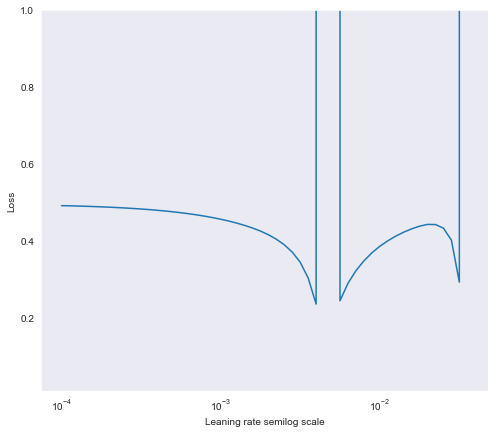

In [183]:
plot_loss(history_vm, 20)

In [188]:
#set a learning rate scheduler to optimize the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : 1e-4 * 10**(epoch/30))

#initalize the model
vanilla_model = vanilla_lstm(input_shape)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 7s 231ms/step - loss: 0.4704
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4699
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4694
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4688
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4682
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4675
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4668
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4660
Epoch 9/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4652
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4643
Epoch 11/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4633
Epoch 12/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4623
Epoch 13/100
29/29 [===============

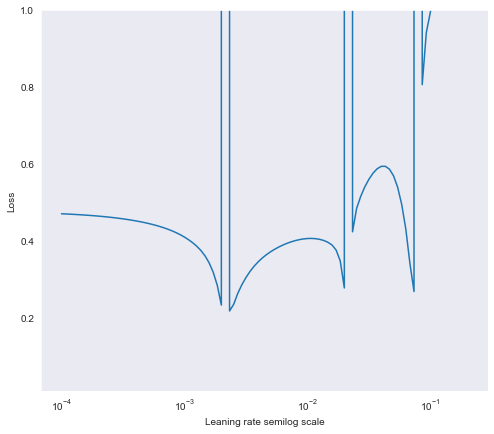

In [190]:
plot_loss_callbacks(history_vm, 30)

##### Long run

After some experimentation we will run the model for 500 epochs on a learning rate of 1e-3.

In [203]:
#initalize the model
vanilla_model = vanilla_lstm(input_shape, learning_rate=1e-3)


history_vm = vanilla_model.fit(X_train, Y_train, epochs=500)

Epoch 1/500
29/29 [==============================] - 5s 176ms/step - loss: 0.4708
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4662
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4616
Epoch 4/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4571
Epoch 5/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4525
Epoch 6/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4479
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4434
Epoch 8/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4386
Epoch 9/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4339
Epoch 10/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4290
Epoch 11/500
29/29 [==============================] - 0s 6ms/step - loss: 0.4240
Epoch 12/500
29/29 [==============================] - 0s 5ms/step - loss: 0.4188
Epoch 13/500
29/29 [===============

Epoch 103/500
29/29 [==============================] - 0s 8ms/step - loss: 0.2233
Epoch 104/500
29/29 [==============================] - 0s 7ms/step - loss: 0.2222
Epoch 105/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2212
Epoch 106/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2202
Epoch 107/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2192
Epoch 108/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2181
Epoch 109/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2171
Epoch 110/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2161
Epoch 111/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2151
Epoch 112/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2141
Epoch 113/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2131
Epoch 114/500
29/29 [==============================] - 0s 5ms/step - loss: 0.2121
Epoch 115/500
29

Epoch 203/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0792
Epoch 204/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0785
Epoch 205/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0777
Epoch 206/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0770
Epoch 207/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0763
Epoch 208/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0756
Epoch 209/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0750
Epoch 210/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0744
Epoch 211/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0738
Epoch 212/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0733
Epoch 213/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0727
Epoch 214/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0722
Epoch 215/500
29

Epoch 303/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0726
Epoch 304/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0698
Epoch 305/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0615
Epoch 306/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 307/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0836
Epoch 308/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0499
Epoch 309/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0646
Epoch 310/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0732
Epoch 311/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0777
Epoch 312/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0796
Epoch 313/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0797
Epoch 314/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0783
Epoch 315/500
29

Epoch 403/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 404/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 405/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 406/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 407/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 408/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 409/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 410/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0420
Epoch 411/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0419
Epoch 412/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 413/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 414/500
29/29 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 415/500
29

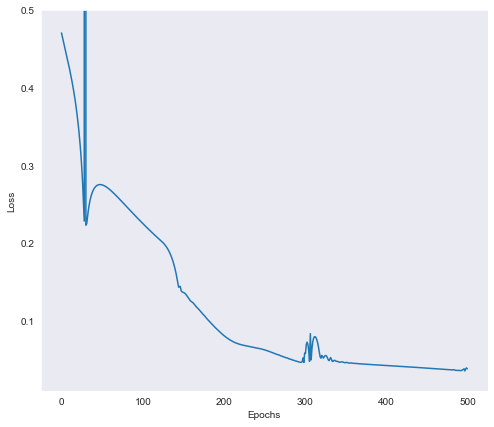

In [204]:
plot_loss(history_vm, semilog=False)

### Make predictions on the test data

In [206]:
Y_hat_test = vanilla_model.predict(X_test)

In [209]:
Y_hat_test.shape, Y_test.shape

((6, 24), (6, 24))

In [30]:
def plot_predictions(Y_hat_test, Y_test):
    fig = plt.figure(figsize=(8,7))

    
    #flatten the hourly slices into single univariate series
    #plot predictions
    plt.plot(Y_hat_test.flatten(), label='Predicted Load')
    #plot actual
    plt.plot(Y_test.flatten(), label='Actual Load')
    
    plt.xlabel('Hours')
    plt.ylabel('Normalized MWh')
    

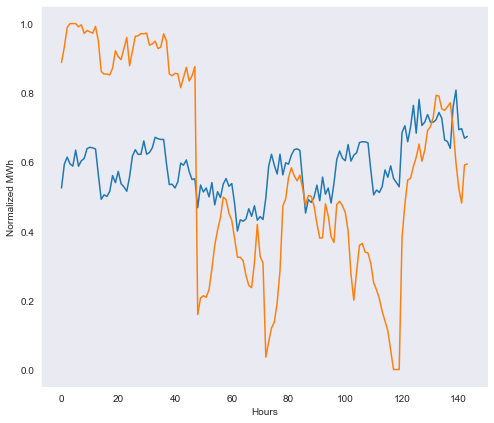

In [234]:
plot_predictions(Y_hat_test, Y_test)

##### Calculate RMSE: Small batch test run



In [255]:
def rescale_results(data, scaler):
    #function rescales the data so when calcualting RMSE we have comparable metrics
    
    return scaler.inverse_transform(data)
    

In [247]:
def convert_df(result, test):
    
    #convert the numpy results back to a dataframe so we can use the calculate_errors helper function
    
    y_cols = ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']
    
    index = test.index
    
    return pd.DataFrame(result, index=index, columns=y_cols)

In [256]:
Y_hat_test_df = convert_df(rescale_results(Y_hat_test, scaler), test)
Y_test_df = convert_df(rescale_results(Y_test, scaler), test)

In [257]:
error_model, errors_hourly = calculate_errors(Y_hat_test_df, Y_test_df, 'LSTM Small Batch')
print('Small batch LSTM 1 month training data, predicting 6 days total RMSE: {}'.format(error_model))

Small batch LSTM 1 month training data, predicting 6 days total RMSE: 3965.835409684048


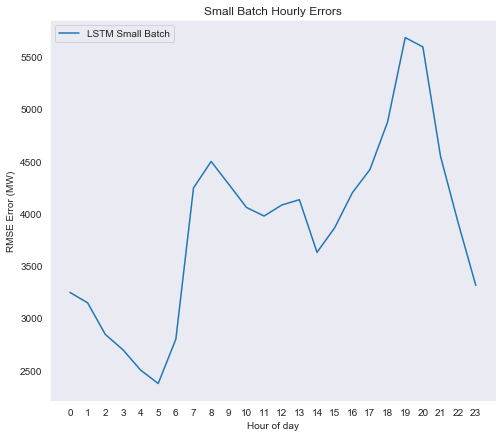

In [260]:
plot_error(errors_hourly, result_set=['LSTM Small Batch'], title='Small Batch Hourly Errors')

### Univariate model with many lags

Based on the results of the SARIMA model we see that early lags were underrepresented in the trend.

Try an LSTM with many features concentrated around last 2 weeks plus one week a month ago.

In [47]:
shift_list = [x for x in range(0,7)] #+ [x for x in range(7,30) if x%2 == 1]

print('Current list of shifts: {}' .format(shift_list))

#load the data set and the inverse scaler
train, test, scaler  = nn_univariate_dataset(start='2017-07-01', stop='2018-03-13', split='2017-12-31', shift_list=shift_list, normalize=True)

print('Number of days in the train set {}'.format(train.shape[0]))
print('Number of days in the test set {}'.format(test.shape[0]))

#prepare the data and get input dims
X, Y, input_shape = prep_data(train, test)

#set the current test X and Y train and test
X_train, X_test = X
Y_train, Y_test = Y

#set the forecast horizon
n_steps_out = 24

Current list of shifts: [0, 1, 2, 3, 4, 5, 6]
Number of days in the train set 178
Number of days in the test set 72


In [48]:
vanilla_model = vanilla_lstm(input_shape, n_steps_out, cells=25, learning_rate=1e-3)

history_vm_extra_lag = vanilla_model.fit(X_train, Y_train, epochs=25, batch_size = 64, validation_split=0.3, shuffle=False)

Train on 124 samples, validate on 54 samples
Epoch 1/25
124/124 [==============================] - 3s 20ms/step - loss: 0.2655 - val_loss: 0.3049
Epoch 2/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2593 - val_loss: 0.2969
Epoch 3/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2523 - val_loss: 0.2885
Epoch 4/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2449 - val_loss: 0.2800
Epoch 5/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2373 - val_loss: 0.2708
Epoch 6/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2291 - val_loss: 0.2608
Epoch 7/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2203 - val_loss: 0.2499
Epoch 8/25
124/124 [==============================] - 1s 8ms/step - loss: 0.2105 - val_loss: 0.2376
Epoch 9/25
124/124 [==============================] - 1s 8ms/step - loss: 0.1995 - val_loss: 0.2234
Epoch 10/25
124/124 [==============================] -

KeyboardInterrupt: 

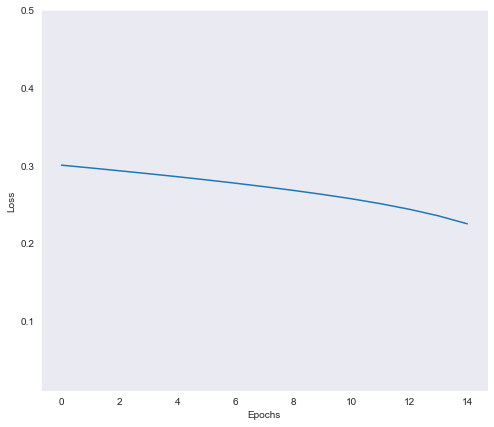

In [55]:
plot_loss(history_vm_extra_lag, semilog=False)

###### Forecast from many lags

In [38]:
Y_hat_many_lag = vanilla_model.predict(X_test)

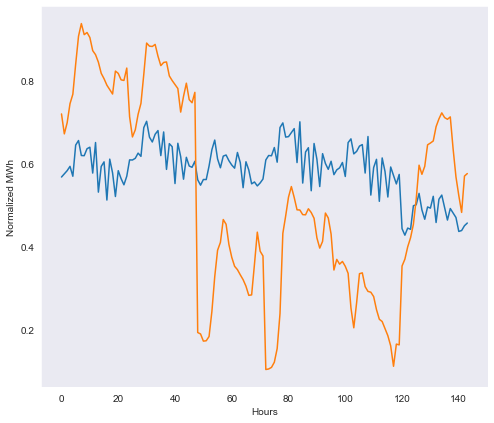

In [39]:
plot_predictions(Y_hat_many_lag, Y_test)

In [80]:
np.isnan(X_train).sum()

0

### Univariate model with 1 Yr data

Train on data from 2016 & 2017

Predict on first 3 months of 2018


In [52]:
shift_list = [0] + [x for x in range(30) if x%2 == 1]

print('Current list of shifts: {}' .format(shift_list))

#load the data set and the inverse scaler
train, test, scaler  = nn_univariate_dataset(start='2017-01-01', stop='2018-03-13', split='2017-12-31', shift_list=shift_list, normalize=True)

print('Number of days in the train set {}'.format(train.shape[0]))
print('Number of days in the test set {}'.format(test.shape[0]))

#prepare the data and get input dims
X, Y, input_shape = prep_data(train, test)

#set the current test X and Y train and test
X_train, X_test = X
Y_train, Y_test = Y

#set the forecast horizon
n_steps_out = 24

Current list of shifts: [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
t-0 h_0      0
t-0 h_1      0
t-0 h_2      0
t-0 h_3      0
t-0 h_4      0
            ..
t-29 h_19    0
t-29 h_20    0
t-29 h_21    0
t-29 h_22    0
t-29 h_23    0
Length: 384, dtype: int64
Number of days in the train set 336
Number of days in the test set 72


Check if there are nans in the file!

In [67]:
np.isnan(Y_test).sum()

0

ValueError: x must have 2 or fewer dimensions

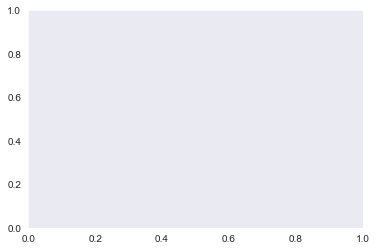

In [69]:
plt.hist(X_train)

In [73]:
data = get_persistence_dataset(start='2018-01-01', stop='2018-02-07', shift=0)
data.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,22779.0,22009.0,20589.0,19547.0,18871.0,18688.0,18869.0,19263.0,19046.0,19563.0,...,23918.0,22626.0,22130.0,22607.0,25198.0,26477.0,27326.0,27534.0,26946.0,24878.0
2018-01-02,28084.0,26180.0,25063.0,24672.0,24537.0,25261.0,27911.0,32762.0,35344.0,36342.0,...,35554.0,35155.0,34958.0,35112.0,36077.0,37957.0,38313.0,37394.0,34645.0,31297.0


In [74]:
data = make_shifted_features(data, [0,1,2,3])
data.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-3 h_14,t-3 h_15,t-3 h_16,t-3 h_17,t-3 h_18,t-3 h_19,t-3 h_20,t-3 h_21,t-3 h_22,t-3 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,24890.0,22892.0,21436.0,20636.0,20276.0,20235.0,20708.0,21220.0,21777.0,23736.0,...,23918.0,22626.0,22130.0,22607.0,25198.0,26477.0,27326.0,27534.0,26946.0,24878.0
2018-01-05,24004.0,22300.0,21162.0,20561.0,20264.0,20037.0,20223.0,20090.0,21114.0,23050.0,...,35554.0,35155.0,34958.0,35112.0,36077.0,37957.0,38313.0,37394.0,34645.0,31297.0


In [31]:
data.columns

Index(['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23',
       't-1 h_0', 't-1 h_1', 't-1 h_2', 't-1 h_3', 't-1 h_4', 't-1 h_5',
       't-1 h_6', 't-1 h_7', 't-1 h_8', 't-1 h_9', 't-1 h_10', 't-1 h_11',
       't-1 h_12', 't-1 h_13', 't-1 h_14', 't-1 h_15', 't-1 h_16', 't-1 h_17',
       't-1 h_18', 't-1 h_19', 't-1 h_20', 't-1 h_21', 't-1 h_22', 't-1 h_23',
       't-2 h_0', 't-2 h_1', 't-2 h_2', 't-2 h_3', 't-2 h_4', 't-2 h_5',
       't-2 h_6', 't-2 h_7', 't-2 h_8', 't-2 h_9', 't-2 h_10', 't-2 h_11',
       't-2 h_12', 't-2 h_13', 't-2 h_14', 't-2 h_15', 't-2 h_16', 't-2 h_17',
       't-2 h_18', 't-2 h_19', 't-2 h_20', 't-2 h_21', 't-2 h_22', 't-2 h_23',
       't-3 h_0', 't-3 h_1', 't-3 h_2', 't-3 h_3', 't-3 h_4', 't-3 h_5',
       't

In [75]:
train, test = train_test_split(data, split_date='2018-02-01')

In [12]:
y_cols = ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']

def make_xy_features(data, y_cols= ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']):
    
    #extract the t-0 hours
    Y_data = data[y_cols]
    
    #drop the t-0 hours leaving only the auto regressive features. 
    X_data = data.drop(columns = y_cols)
    
    
    return X_data, Y_data
    
    

In [76]:
X_train, Y_train = make_xy_features(train, y_cols)
X_test, Y_test = make_xy_features(test, y_cols)

In [35]:
X_train.head(2)

,t-1 h_0,t-1 h_1,t-1 h_2,t-1 h_3,t-1 h_4,t-1 h_5,t-1 h_6,t-1 h_7,t-1 h_8,t-1 h_9,...,t-3 h_14,t-3 h_15,t-3 h_16,t-3 h_17,t-3 h_18,t-3 h_19,t-3 h_20,t-3 h_21,t-3 h_22,t-3 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,28930.0,26848.0,25598.0,25203.0,24987.0,25730.0,28433.0,32647.0,35564.0,36996.0,...,23918.0,22626.0,22130.0,22607.0,25198.0,26477.0,27326.0,27534.0,26946.0,24878.0
2018-01-05,24890.0,22892.0,21436.0,20636.0,20276.0,20235.0,20708.0,21220.0,21777.0,23736.0,...,35554.0,35155.0,34958.0,35112.0,36077.0,37957.0,38313.0,37394.0,34645.0,31297.0


In [36]:
Y_train.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,24890.0,22892.0,21436.0,20636.0,20276.0,20235.0,20708.0,21220.0,21777.0,23736.0,...,24932.0,23987.0,23262.0,22859.0,22924.0,23696.0,26026.0,28770.0,27734.0,26027.0
2018-01-05,24004.0,22300.0,21162.0,20561.0,20264.0,20037.0,20223.0,20090.0,21114.0,23050.0,...,25099.0,23834.0,23017.0,22735.0,22835.0,23281.0,24770.0,27316.0,26745.0,24843.0


In [38]:
X_test.head(2)

,t-1 h_0,t-1 h_1,t-1 h_2,t-1 h_3,t-1 h_4,t-1 h_5,t-1 h_6,t-1 h_7,t-1 h_8,t-1 h_9,...,t-3 h_14,t-3 h_15,t-3 h_16,t-3 h_17,t-3 h_18,t-3 h_19,t-3 h_20,t-3 h_21,t-3 h_22,t-3 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,22657.0,20818.0,19741.0,19276.0,19192.0,20003.0,22852.0,26479.0,29437.0,31639.0,...,34430.0,33799.0,33430.0,33438.0,34663.0,36846.0,37348.0,36600.0,33758.0,30372.0
2018-02-03,28904.0,26773.0,25649.0,25283.0,25106.0,25789.0,28342.0,33292.0,35998.0,37478.0,...,34052.0,33372.0,33102.0,33198.0,34434.0,36538.0,37134.0,36390.0,33770.0,30380.0


In [39]:
Y_test.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,28904.0,26773.0,25649.0,25283.0,25106.0,25789.0,28342.0,33292.0,35998.0,37478.0,...,36008.0,35299.0,34953.0,34723.0,35511.0,37468.0,37644.0,36901.0,34549.0,31734.0
2018-02-03,28838.0,26702.0,25497.0,25071.0,24925.0,25580.0,28170.0,32461.0,35469.0,36918.0,...,35909.0,35226.0,34984.0,34771.0,34690.0,36276.0,37210.0,36187.0,33867.0,31129.0


OK univariate features setup for input into a LSTM

## Setting up Vanilla LSTM

In [40]:
X_train.shape

(29, 72)

In [77]:
#number of channels of data. univariate is ONLY energy data
n_features = 1

#number of autoregressive feautres * hours in day
n_steps_in = X_train.shape[1]

#number of steps ahead to forecast
n_steps_out = Y_train.shape[1]

#the number of samples in the test
n_samples_train = X_train.shape[0] 
n_samples_test = X_test.shape[0]
 
print('Training samples: {}, Autoregressive features {} hours, Forecast horizon {} hours' .format(n_samples_train, n_steps_in, n_steps_out))
print('Test samples: {}, Autoregressive features {} hours, Forecast horizon {} hours' .format(n_samples_test, n_steps_in, n_steps_out))

Training samples: 29, Autoregressive features 72 hours, Forecast horizon 24 hours
Test samples: 6, Autoregressive features 72 hours, Forecast horizon 24 hours


In [83]:
## set up a vanilla model
model_vanilla = keras.models.Sequential()
model_vanilla.add(keras.layers.LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model_vanilla.add(keras.layers.Dense(n_steps_out))
model_vanilla.compile(optimizer='adam', loss='mse')

In [79]:
#reshape the dfs into input shape as np array
X_train = np.reshape(X_train.values, (n_samples_train, n_steps_in, n_features))
X_test = np.reshape(X_test.values, (n_samples_test, n_steps_in, n_features))

In [80]:
Y_train = Y_train.values
Y_test = Y_test.values

In [81]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((29, 72, 1), (29, 24), (6, 72, 1), (6, 24))

In [84]:
history = model_vanilla.fit(X_train, Y_train, epochs=5)

Epoch 1/5
29/29 [==============================] - 2s 57ms/step - loss: 1188704768.0000
Epoch 2/5
29/29 [==============================] - 0s 5ms/step - loss: 1341474432.0000
Epoch 3/5
29/29 [==============================] - 0s 5ms/step - loss: 1238581760.0000
Epoch 4/5
29/29 [==============================] - 0s 6ms/step - loss: 1152589952.0000
Epoch 5/5
29/29 [==============================] - 0s 5ms/step - loss: 1302741248.0000


In [ ]:
Y_test_hat = model_vanilla.predict(X_test)